In [1]:
import statsapi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
players = pd.read_csv("mlb_players_2021.csv")
pitches = pd.read_csv("regseason.csv")

In [3]:
players.rename(columns = {"id" : "batter","fullName" : "batter_fullName" , "birthCountry" : "batter_birthCountry"}, inplace = True)
players.head()

,batter,batter_fullName,birthDate,batter_birthCountry,height,weight,primaryPosition,batSide,pitchHand,debutDate,active
0,642758,Domingo Acevedo,1994-03-06,Dominican Republic,"6' 7""",240,P,R,R,2021-06-21,True
1,664119,Austin Allen,1994-01-16,USA,"6' 1""",219,C,L,R,2019-05-11,False
2,462101,Elvis Andrus,1988-08-26,Venezuela,"6' 0""",210,SS,R,R,2009-04-06,False
3,642456,Luis Barrera,1995-11-15,Dominican Republic,"6' 0""",195,OF,L,L,2021-05-19,True
4,605135,Chris Bassitt,1989-02-22,USA,"6' 5""",217,P,R,R,2014-08-30,True


In [4]:
pitches.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat
0,1,SL,2021-10-03,85.1,2.39,6.05,"Detmers, Reid",641487,672282,single,...,2,4,Standard,Standard,293.0,0.079,0.780,0_1,bLpL,breaking
1,2,FF,2021-10-03,93.8,2.31,6.03,"Detmers, Reid",641487,672282,NaN,...,1,4,Standard,Standard,150.0,0.000,-0.045,0_0,bLpL,fastball
2,3,CU,2021-10-03,73.9,2.12,6.25,"Detmers, Reid",664238,672282,strikeout,...,1,4,Standard,Standard,329.0,-0.032,-0.315,2_2,bRpL,breaking
3,4,FF,2021-10-03,94.6,2.43,5.96,"Detmers, Reid",664238,672282,NaN,...,1,4,Standard,Standard,146.0,0.000,0.047,1_2,bRpL,fastball
4,5,FF,2021-10-03,94.3,2.08,6.15,"Detmers, Reid",664238,672282,NaN,...,1,4,Standard,Standard,151.0,0.000,0.000,1_2,bRpL,fastball


In [5]:
# Merge pitches df with info about the batter
full_df = pd.merge(pitches, players[["batter","batter_fullName","batSide", "batter_birthCountry"]], on = "batter")
full_df.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat,batter_fullName,batSide,batter_birthCountry
0,1,SL,2021-10-03,85.1,2.39,6.05,"Detmers, Reid",641487,672282,single,...,Standard,293.0,0.079,0.780,0_1,bLpL,breaking,J.P. Crawford,L,USA
1,2,FF,2021-10-03,93.8,2.31,6.03,"Detmers, Reid",641487,672282,NaN,...,Standard,150.0,0.000,-0.045,0_0,bLpL,fastball,J.P. Crawford,L,USA
2,3,CU,2021-10-03,73.9,2.12,6.25,"Detmers, Reid",664238,672282,strikeout,...,Standard,329.0,-0.032,-0.315,2_2,bRpL,breaking,Dylan Moore,R,USA
3,4,FF,2021-10-03,94.6,2.43,5.96,"Detmers, Reid",664238,672282,NaN,...,Standard,146.0,0.000,0.047,1_2,bRpL,fastball,Dylan Moore,R,USA
4,5,FF,2021-10-03,94.3,2.08,6.15,"Detmers, Reid",664238,672282,NaN,...,Standard,151.0,0.000,0.000,1_2,bRpL,fastball,Dylan Moore,R,USA


In [6]:
# Remove the pitches that were fouled, in play, or swung at
not_hit = ["called_strike", "ball"]
pitches_not_hit = full_df[full_df['description'].isin(not_hit)].copy()
len(pitches_not_hit)

390288

So we have 390,000 pitches to work with that were thrown but not swung at or hit

In [7]:
# Check that we only have balls and called strikes
pitches_not_hit['description'].unique()

array(['called_strike', 'ball'], dtype=object)

In [8]:
pitches_not_hit["strike_zone"] = pitches_not_hit["zone"] <= 9 # Determine if the pitch was actually in the zone

pitches_not_hit["called_correctly"] = (
    ((pitches_not_hit["zone"] <= 9) & (pitches_not_hit["type"] == "S")) | # Pitch is in the zone and is called a strike  
    ((pitches_not_hit["zone"] > 9) & (pitches_not_hit["type"] == "B"))    # Pitch is not in the zone and is called a ball
) 
pitches_not_hit["called_correctly"] = pitches_not_hit["called_correctly"].astype(int) # This will be are target variable -- whether the pitch was called "correctly"

In [9]:
# Check how many pitches we have that were "called correctly"
len(pitches_not_hit[pitches_not_hit["called_correctly"] == 1])

357779

In [10]:
# Check how many pitches we have that were not "called correctly"
len(pitches_not_hit[pitches_not_hit["called_correctly"] == 0])

32509

So there are aound 360,000 correctly called pitches at 32,000 which are not called correctly -- we might want to consider removing some of the correctly called pitches so that we have the same amount for each. But 64,000 data points should be enough for training our model. 

# Feature Visualization

Before training a model, lets visualize some features of the dataset with relation to our target variable "called correctly" to help identify features which may be prevalent to the outcomes of our model. Lets start with release speed, with the idea that faster pitches are harder to call as the umpire will have less to to analyze the pitch and make the call. 

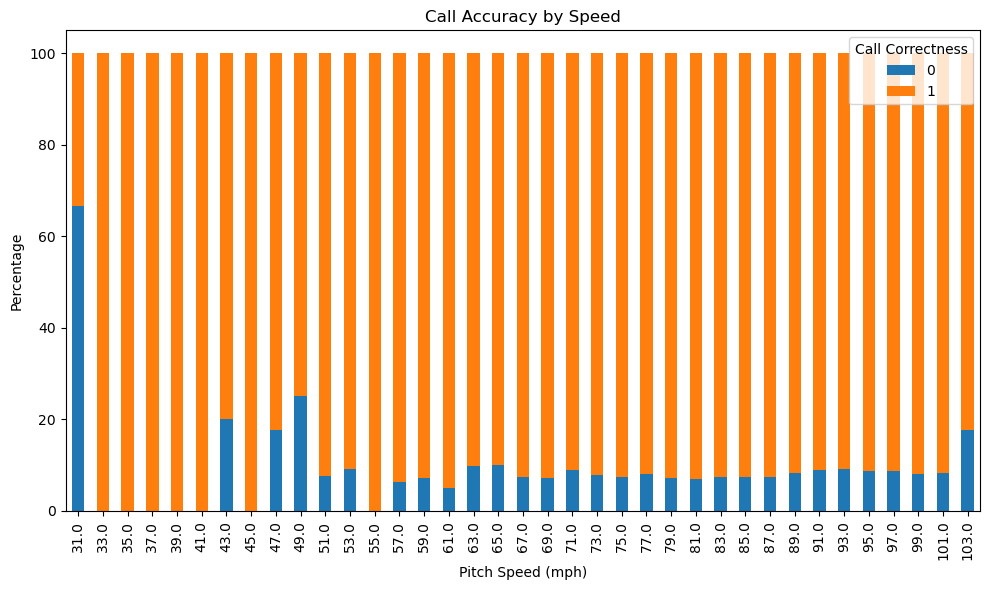

In [11]:
# create 2 mph speed groups
pitches_not_hit["speed_group"] = pitches_not_hit["release_speed"] // 2 

# Count pitches per speed_group and call correctness
grouped = pitches_not_hit.groupby(['speed_group', 'called_correctly']).size().unstack()

# Convert to percentage (so each bar sums to 100)
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Recalculate midpoint speeds
grouped_percent.index = grouped_percent.index * 2 + 1  # 2 * group + 1 = midpoint

# Plot
grouped_percent.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.ylabel("Percentage")
plt.xlabel("Pitch Speed (mph)")
plt.title("Call Accuracy by Speed")
plt.legend(title = "Call Correctness", loc = "upper right")
plt.tight_layout()
plt.show()


Interestingly, it seems like pitch speed has little relationship to call accuracy. Lets now look at how release position affects call accuracy.

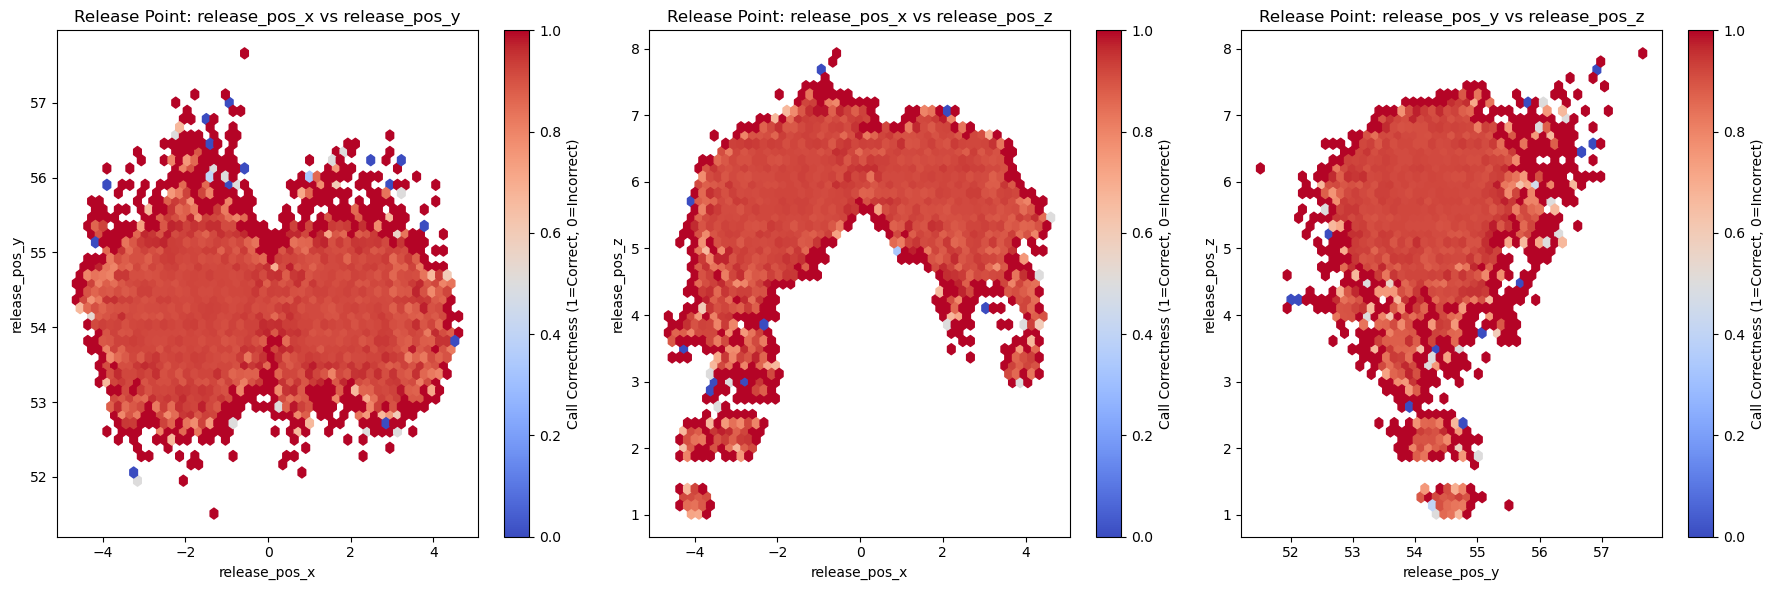

In [12]:
# create a density plot of release position in the x and y axis
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

# List of combinations for x, y, and z axes
combinations = [
    ('release_pos_x', 'release_pos_y'),
    ('release_pos_x', 'release_pos_z'),
    ('release_pos_y', 'release_pos_z')
]

# Loop over the combinations and plot hexbin on each subplot
for ax, (x_var, y_var) in zip(axes, combinations):
    hb = ax.hexbin(
        pitches_not_hit[x_var], 
        pitches_not_hit[y_var], 
        C = pitches_not_hit['called_correctly'],  # Color by correctness
        gridsize = 50, 
        cmap='coolwarm'
    )
    cb = fig.colorbar(hb, ax = ax, label = 'Call Correctness (1=Correct, 0=Incorrect)')
    ax.set_title(f"Release Point: {x_var} vs {y_var}")
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)

# Adjust layout
plt.tight_layout()
plt.show()

Generally, MLB umpires seem to be very good at calling pitches correctly. It doesn't seem like release position has a large impact on call correctness, although there may be marginally lower accuracy along the edges of the distributions. Lets see if spin rate has any affect, as pitches with more spin may be harder to predict. 

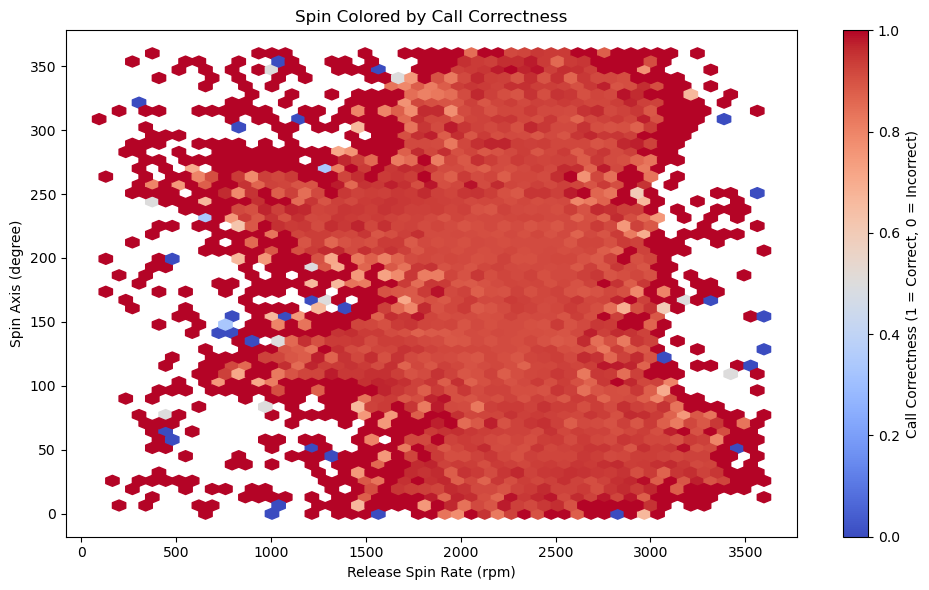

In [13]:
# create a density plot of release spin rate vs spin axis in the x and y axis

# Create the hexbin plot with color based on 'called_correctly'
plt.figure(figsize = (10, 6))
hb = plt.hexbin(
    pitches_not_hit['release_spin_rate'], 
    pitches_not_hit['spin_axis'], 
    C = pitches_not_hit['called_correctly'],  # Color by correctness
    gridsize = 50, 
    cmap = 'coolwarm'
)

# Add a colorbar
cb = plt.colorbar(hb, label='Call Correctness (1 = Correct, 0 = Incorrect)')

# Add labels and title
plt.title("Spin Colored by Call Correctness")
plt.xlabel("Release Spin Rate (rpm)")
plt.ylabel("Spin Axis (degree)")

plt.tight_layout()
plt.show()

Spin rate and spin axis seem to have even little effect on call correctness. Let's now look at categorical variables such as pitch_type, game_type,inning, and inning topbot.

# Generating a Model and Assessing its Bias

For this model we will subset our features to exclude where the actual pitch is when it crosses the plate, i.e. strike zone false/true and strike zone, and instead focus on features describing how the pitche was released and the gamestate when the pitch was thrown such pitch and inning count. First we will downsample and set up our training and testing split. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Creating a new variable to see if a game altering event (out or man on base) came as a result of the pitch
pitches_not_hit['has_event'] = pitches_not_hit['events'].notna().astype(int) 

y = pitches_not_hit["called_correctly"]
X = pitches_not_hit.drop(["called_correctly"], axis = 1)


# Combining into a new df
X_df = X.copy()
X_df['target'] = y

# Split into correct/incorrect
majority = X_df[X_df['target'] == 1]  # Correct calls
minority = X_df[X_df['target'] == 0]  # Incorrect calls

# Downsample majority
majority_downsampled = resample(
    majority,
    replace = False,# No replacement
    n_samples = len(minority),# Match number of minority examples
    random_state = 42
)

# Combine back
balanced = pd.concat([majority_downsampled, minority])
balanced = balanced.sample(frac = 1, random_state = 42).reset_index(drop = True)

# Set up x and y train balanced
X_balanced = balanced.drop(columns = ['target'])
y_balanced = balanced['target']

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced)

Select only the columns we want.

In [15]:
all_quant_cols_pi = [  # only numerical features that don't show where the pitch ends up
    'release_speed', 'release_pos_x', 'release_pos_z','balls', 'strikes',
    'outs_when_up', 'inning',
    'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate', 'release_extension',
    'release_pos_y', 'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score',
    'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score',
    'post_fld_score', 'spin_axis', 'delta_run_exp', 'delta_home_win_exp', 'has_event' #took out zone
]

all_qual_cols_pi = [ # only qualitiative features that don't show where the pitch ends up
    'pitch_type', 'events', 'description', 'game_type',
    'stand', 'p_throws', 'inning_topbot', 'pitch_name',
    'if_fielding_alignment', 'of_fielding_alignment', 'count', 'PBhand', 'pitch_cat', 
    'batSide',  #took out strike zone, and type which indicate what the pitch type is as well as game date and des
]

Use a one-hot-encoder in the model to pre-process the data for all the qualitative columns.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import random

random.seed(123)
qual_cols = all_qual_cols_pi
quant_cols = all_quant_cols_pi

# preprocessing for numeric and categorical columns
preprocessor = ColumnTransformer(
    transformers = [
        ('num', 'passthrough', quant_cols),
        ('cat', Pipeline([
        ('encoder', OneHotEncoder(handle_unknown= 'ignore'))]), qual_cols) 
    ]
)

# Combine preprocessor with a logistic regression model
clf = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 100000))])

# Cleaning out rows with NaNs and re-fitting y to match
X_train_clean = X_train[quant_cols + qual_cols].dropna() # so we don't have NA errors
y_train_clean = y_train.loc[X_train_clean.index]

X_test_clean = X_test[quant_cols + qual_cols].dropna()
y_test_clean = y_test.loc[X_test_clean.index]

# fit model on training set
clf.fit(X_train_clean, y_train_clean) 

# Evaluate on both training and test sets
train_score = accuracy_score(y_train_clean, clf.predict(X_train_clean))
test_score = accuracy_score(y_test_clean, clf.predict(X_test_clean))

print(f" Training Accuracy: {train_score:.4f}")
print(f" Test Accuracy: {test_score:.4f}")

 Training Accuracy: 0.7095
 Test Accuracy: 0.6837


c:\Users\miceo\anaconda3\envs\ml-0451\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


It seems that our model is able to predict whether or not the umpire makes the right a little better than call 2/3 of the time despite not knowing where the pitch ends up which implies there are factors other than the actual position the pitch crosses the plate which could be affecting umpire accuracy. Let's explore bias in the model by first looking at the accuracy for calling balls and strikes.

In [17]:
# start by separating data into balls and strikes
X_strikes = X_test_clean[X_test["strike_zone"] == True]
X_balls = X_test_clean[X_test["strike_zone"] == False]
y_strikes = y_test_clean[X_test["strike_zone"] == True]
y_balls = y_test_clean[X_test["strike_zone"] == False]

# pull accuracy scores for ptiches that were strikes and pitches that were balls
strikes_acc = accuracy_score(y_strikes, clf.predict(X_strikes))
balls_acc = accuracy_score(y_balls, clf.predict(X_balls))

# print the accuracy
print(f" Strikes Accuracy: {strikes_acc:.4f}")
print(f" Balls Accuracy: {balls_acc:.4f}")

 Strikes Accuracy: 0.0443
 Balls Accuracy: 0.9676


C:\Users\miceo\AppData\Local\Temp\ipykernel_21408\250145632.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_strikes = X_test_clean[X_test["strike_zone"] == True]
C:\Users\miceo\AppData\Local\Temp\ipykernel_21408\250145632.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_balls = X_test_clean[X_test["strike_zone"] == False]


Interestingly, our model is exceptionally bad at predicting whether or not the umpire will make the correct call when the pitch is a strike (in fact our model almost never does), but is exceptionally good at predicting what the umpire will call when the pitch is a ball. Lets compare the model's predictive accuracy to the actual accuracy rates and then generate an ROC curve for this data.

In [18]:
# pull the real accuracy rates from the data
strikes_real_acc = np.mean(pitches_not_hit["called_correctly"][pitches_not_hit["strike_zone"] == True])
balls_real_acc = np.mean(pitches_not_hit["called_correctly"][pitches_not_hit["strike_zone"] == False])

# start by separating data into balls and strikes
X_strikes = X_test_clean[X_test["strike_zone"] == True]
X_balls = X_test_clean[X_test["strike_zone"] == False]

# pull accuracy scores for ptiches that were strikes and pitches that were balls
strikes_pred = clf.predict(X_strikes).mean()
balls_pred = clf.predict(X_balls).mean()

from tabulate import tabulate

# Create the data as a list of lists
table_data = [
    ["Call Type", "Umpire Accuracy (Model)", "Actual Accuracy"],
    ["Strike", f"{strikes_pred:.4f}", f"{strikes_real_acc:.4f}"],
    ["Ball", f"{balls_pred:.4f}", f"{balls_real_acc:.4f}"]
]

# Print the table
print(tabulate(table_data, headers = "firstrow", tablefmt = "grid"))

+-------------+---------------------------+-------------------+
| Call Type   |   Umpire Accuracy (Model) |   Actual Accuracy |
+=============+===========================+===================+
| Strike      |                    0.4479 |            0.8956 |
+-------------+---------------------------+-------------------+
| Ball        |                    0.3549 |            0.9264 |
+-------------+---------------------------+-------------------+


C:\Users\miceo\AppData\Local\Temp\ipykernel_21408\3084065241.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_strikes = X_test_clean[X_test["strike_zone"] == True]
C:\Users\miceo\AppData\Local\Temp\ipykernel_21408\3084065241.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_balls = X_test_clean[X_test["strike_zone"] == False]


In the our actual data, Umpire's are more likely to make the incorrect call on strikes than balls but the disrepancy is nowhere close to as large as the discrepancy in our model. Our model is also predicting that umpire's make the correct call much less frequently than they actually do; the relationship between balls and strikes has also been flipped. Let's take generate an ROC curve and then look at which features are being weighted the heaviest.

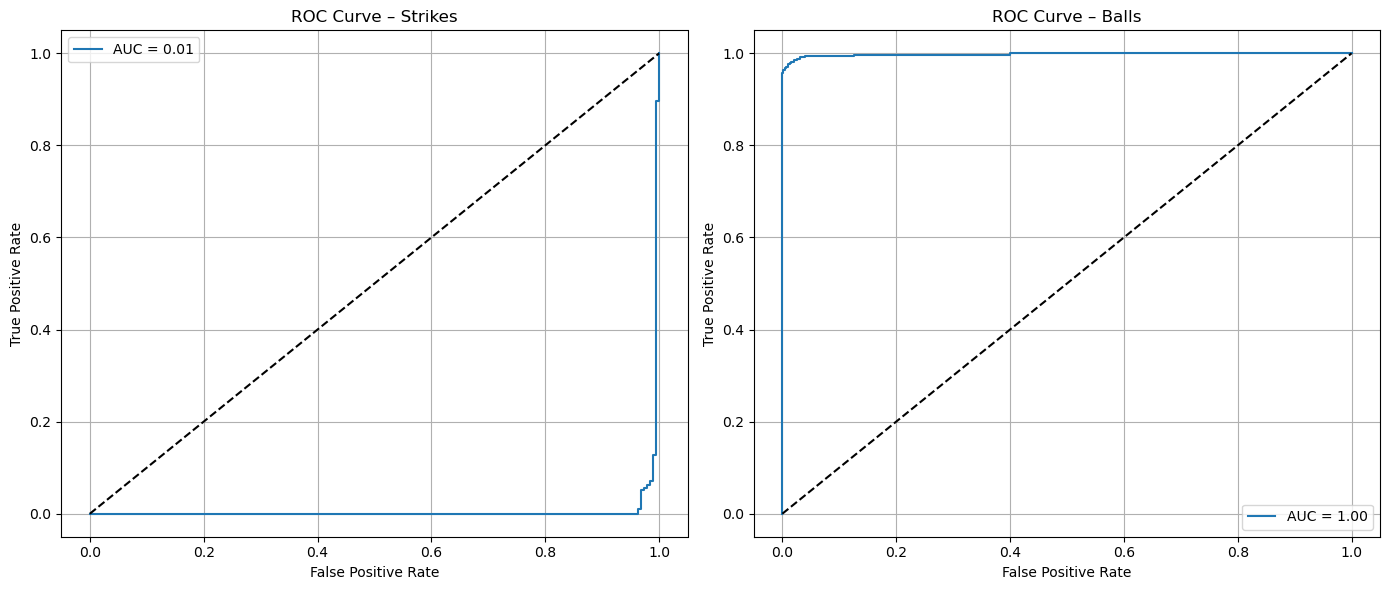

In [19]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_strikes_scores = clf.predict_proba(X_strikes)[:, 1]
y_balls_scores = clf.predict_proba(X_balls)[:, 1]

# Compute ROC curve values
fpr_strikes, tpr_strikes, _ = roc_curve(y_strikes, y_strikes_scores)
roc_auc_strikes = auc(fpr_strikes, tpr_strikes)

fpr_balls, tpr_balls, _ = roc_curve(y_balls, y_balls_scores)
roc_auc_balls = auc(fpr_balls, tpr_balls)

# Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize = (14, 6))

# Plot Strike ROC
axs[0].plot(fpr_strikes, tpr_strikes, label = f'AUC = {roc_auc_strikes:.2f}')
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_title('ROC Curve – Strikes')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend()
axs[0].grid()

# Plot Ball ROC
axs[1].plot(fpr_balls, tpr_balls, label = f'AUC = {roc_auc_balls:.2f}')
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_title('ROC Curve – Balls')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend()
axs[1].grid()

# Show both plots
plt.tight_layout()
plt.show()

Our ROC curves of balls vs strikes confrims that our model is exceptionally bad at predicting whether the umpire makes the correct call for balls and exceptionally good at predicting whether the umpire makes the correct call for strikes. Lets view the confustion matrix for this model to understand where the model is making mistakes.

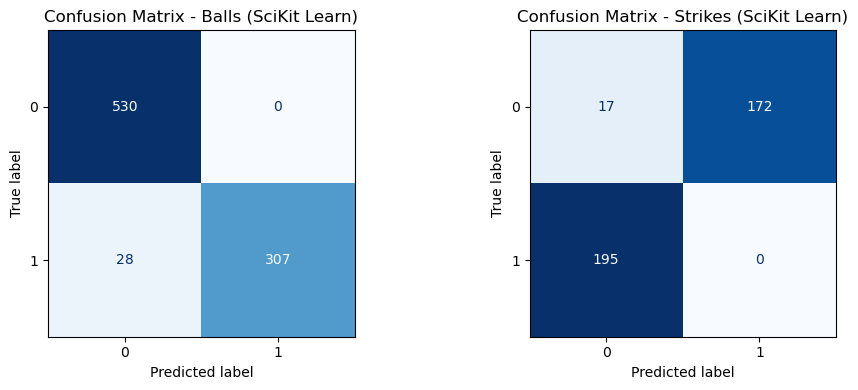

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions for balls and strikes
y_pred_balls = clf.predict(X_balls)
y_pred_strikes = clf.predict(X_strikes)

# Generate confustion matrices for balls and strikes
cm_balls = confusion_matrix(y_balls, y_pred_balls)
cm_strikes = confusion_matrix(y_strikes, y_pred_strikes)

# plot
plt.figure(figsize = (10, 4))

# Plot for Balls
plt.subplot(1, 2, 1)
disp_balls = ConfusionMatrixDisplay(confusion_matrix = cm_balls)
disp_balls.plot(cmap = plt.cm.Blues, ax = plt.gca(), colorbar = False)
plt.title("Confusion Matrix - Balls (SciKit Learn)")

# Plot for Strikes
plt.subplot(1, 2, 2)
disp_strikes = ConfusionMatrixDisplay(confusion_matrix=  cm_strikes)
disp_strikes.plot(cmap = plt.cm.Blues, ax = plt.gca(), colorbar = False)
plt.title("Confusion Matrix - Strikes (SciKit Learn)")

# Display both plots
plt.tight_layout()
plt.show()

The confusion matrix confirms what we would expect. The model is extremely good at predicting the true label for balls and horrible and predicting the true label for strikes. Let's look at what features are being weighted heavily in this model.

C:\Users\miceo\AppData\Local\Temp\ipykernel_21408\2853885829.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Weight', y = 'Feature', data = coef_df_sorted, palette = 'coolwarm')


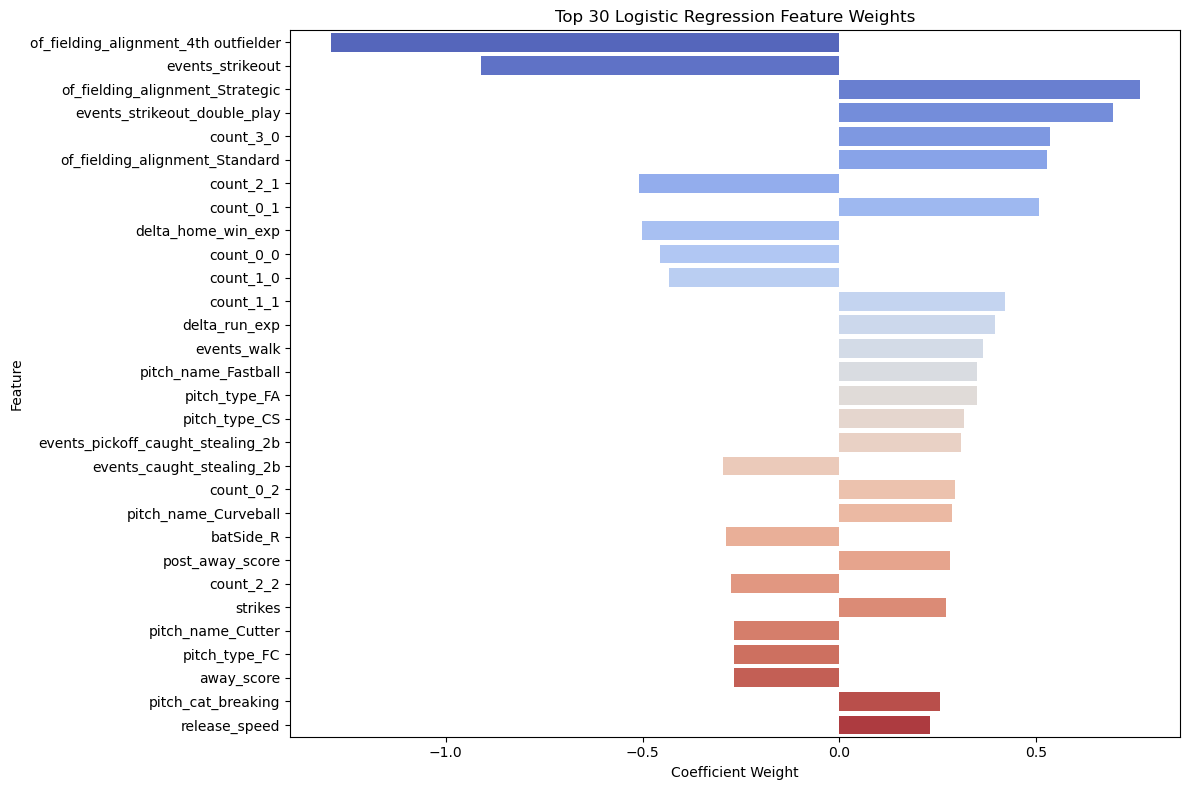

In [21]:
# Get the ecoded column names
ohe = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
ohe_feature_names = ohe.get_feature_names_out(qual_cols)

#combine numeric and encoded categorical feature names
feature_names = quant_cols + list(ohe_feature_names)

# Collect matching coefficents
coefficients = clf.named_steps['classifier'].coef_[0]

# Put coefficients into a DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': coefficients})

# Sort by absolute value weight
coef_df['abs_weight']= coef_df['Weight'].abs()
coef_df_sorted = coef_df.sort_values(by = 'abs_weight', ascending = False).head(30)  # top 30 most important

#Plot
plt.figure(figsize = (12, 8))
sns.barplot(x = 'Weight', y = 'Feature', data = coef_df_sorted, palette = 'coolwarm')
plt.title('Top 30 Logistic Regression Feature Weights')
plt.xlabel('Coefficient Weight')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Some of the features which are being weighted are a little odd. Part of our problem may also be that our model is not fully converging. We will try using an advanced optimizer which implements Newton's method descent with a momentum term.

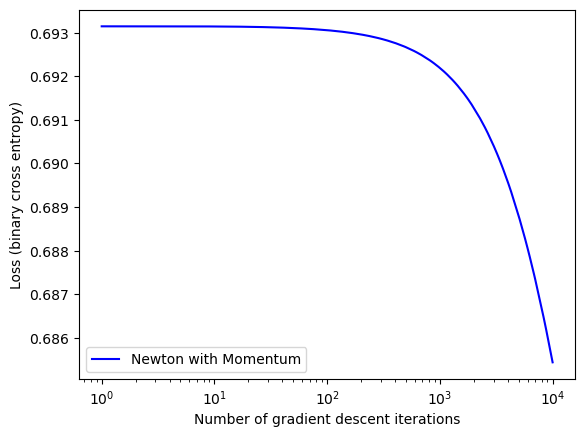

In [22]:
from AdvancedOptimization import LogisticRegression, NewtonOptimizer
import torch

# Drop NaS and fill with 0
X_train_clean = X_train_clean.fillna(0)

# Preprocess the data and fit the transformer
preprocessor.fit(X_train_clean)
X_train_clean_transformed = preprocessor.transform(X_train_clean)

# Convert to torch tensors
X_train_clean_tensor = torch.tensor(X_train_clean_transformed, dtype = torch.float32)
y_train_clean_tensor = torch.tensor(y_train_clean.values, dtype = torch.float32)

# Instantiate the Model
LR = LogisticRegression()
opt = NewtonOptimizer(LR)

# for keeping track of loss values
loss_vec = []
loss = 1

# iterables
max_iter = 10000
iter = 0

# training loop to iterate through optimization steps and avoid a false convergence
while (loss > 1e-5 and iter < max_iter):
    
    # Track loss values
    loss_vec.append(LR.loss(X_train_clean_tensor, y_train_clean_tensor))

    # Perform optimization step with small alpha and a reasonable momentum term
    opt.step(X_train_clean_tensor, y_train_clean_tensor, .01, .9) 

    # update iterables
    loss = LR.loss(X_train_clean_tensor, y_train_clean_tensor)
    iter += 1

# Plot loss over iterations
plt.plot(range(1, len(loss_vec) + 1), loss_vec, color = "blue", label = "Newton with Momentum")
plt.semilogx()
plt.xlabel("Number of gradient descent iterations")
plt.ylabel("Loss (binary cross entropy)")
plt.legend()
plt.show()

Unfortunately, we were not able to get the loss to converge to 0 through 10000 iterations because we do not have enough computing power. Before we audit, lets tray decreasing the learning rate and performing more iterations.

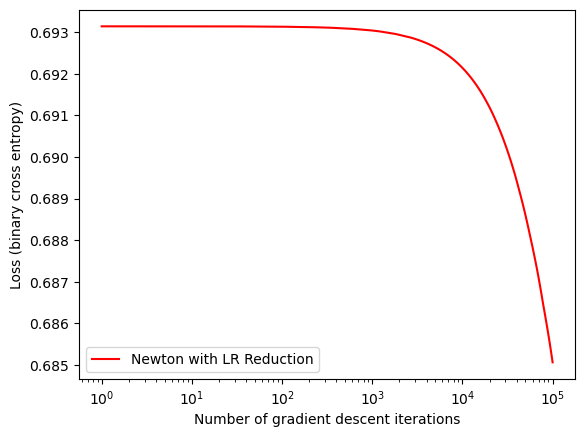

In [32]:
# Instantiate a new Model
LR2 = LogisticRegression()
opt2 = NewtonOptimizer(LR2)

# for keeping track of loss values
loss2_vec = []
loss2 = 1

# iterables
max_iter = 100000
iter = 0

# training loop to iterate through optimization steps and avoid a false convergence
while (loss2 > 1e-5 and iter < max_iter):
    
    # Track loss values
    loss2_vec.append(LR2.loss(X_train_clean_tensor, y_train_clean_tensor))

    # Perform optimization step with a smaller alpha and a reasonable momentum term
    opt2.step(X_train_clean_tensor, y_train_clean_tensor, .001, .9) 

    # update iterables
    loss2 = LR2.loss(X_train_clean_tensor, y_train_clean_tensor)
    iter += 1

# Plot loss over iterations
plt.plot(range(1, len(loss2_vec) + 1), loss2_vec, color = "red", label = "Newton with LR Reduction")
plt.semilogx()
plt.xlabel("Number of gradient descent iterations")
plt.ylabel("Loss (binary cross entropy)")
plt.legend()
plt.show()

It is clear that the minimum loss has not yet been achieved, but that with more computing power it may be possible to reduce the loss significantly. Lets perform the same audting of pitch bias as we did before for our simple logisitic regression model on our advanced model using a Newton optimizer with momemntum based descent. Let's start by looking at simple accuracy in both the training and test sets for both our models

In [23]:
# Drop NaS and fill with 0
X_test_clean_ = X_test_clean.fillna(0)

# Preprocess the data with the same processor as the training data
X_test_clean_transformed = preprocessor.transform(X_test_clean)

# Convert to torch tensors
X_test_clean_tensor = torch.tensor(X_test_clean_transformed, dtype = torch.float32)
y_test_clean_tensor = torch.tensor(y_test_clean.values, dtype = torch.float32)

# Evaluate on both training and test sets
train_score1 = accuracy_score(y_train_clean_tensor, LR.predict(X_train_clean_tensor))
test_score1 = accuracy_score(y_test_clean_tensor, LR.predict(X_test_clean_tensor))
train_score2 = accuracy_score(y_train_clean_tensor, LR2.predict(X_train_clean_tensor))
test_score2 = accuracy_score(y_test_clean_tensor, LR2.predict(X_test_clean_tensor))

print(f" Training Accuracy Model 1: {train_score:.4f}")
print(f" Test Accuracy Model 1: {test_score:.4f}")
print(f" Training Accuracy Model 2: {train_score2:.4f}")
print(f" Test Accuracy Model 2: {test_score2:.4f}")

NameError: name 'LR2' is not defined

The first model has a much better accuracy thus we will continue on experiments with model 1; although with a smaller LR, if we had more computational power to run through more iterations the second model would likely perform better. 

In [24]:
# convert pitch and balls data used before to the proper tensor format
# convet NAs
X_strikes = X_strikes.fillna(0)
X_balls = X_balls.fillna(0)

# Preprocess the data with the same processor as the training data
X_strikes_clean = preprocessor.transform(X_strikes)
X_balls_clean = preprocessor.transform(X_balls)

# Convert to torch tensors
X_strikes_clean_tensor = torch.tensor(X_strikes_clean, dtype = torch.float32)
X_balls_clean_tensor = torch.tensor(X_balls_clean, dtype = torch.float32)
y_strikes_clean_tensor = torch.tensor(y_strikes.values, dtype = torch.float32)
y_balls_clean_tensor = torch.tensor(y_balls.values, dtype = torch.float32)

# pull accuracy scores for ptiches that were strikes and pitches that were balls
strikes_acc = accuracy_score(y_strikes_clean_tensor, LR.predict(X_strikes_clean_tensor))
balls_acc = accuracy_score(y_balls_clean_tensor, LR.predict(X_balls_clean_tensor))

# print the accuracy
print(f" Strikes Accuracy: {strikes_acc:.4f}")
print(f" Balls Accuracy: {balls_acc:.4f}")

 Strikes Accuracy: 0.4922
 Balls Accuracy: 0.6127


This is extremely interesting. With our custom model, altough we have achieved a similar overall accuracy we achieved a much more even accuracy across balls and strikes whithin the data. This should be reflected in the ROC curves. 

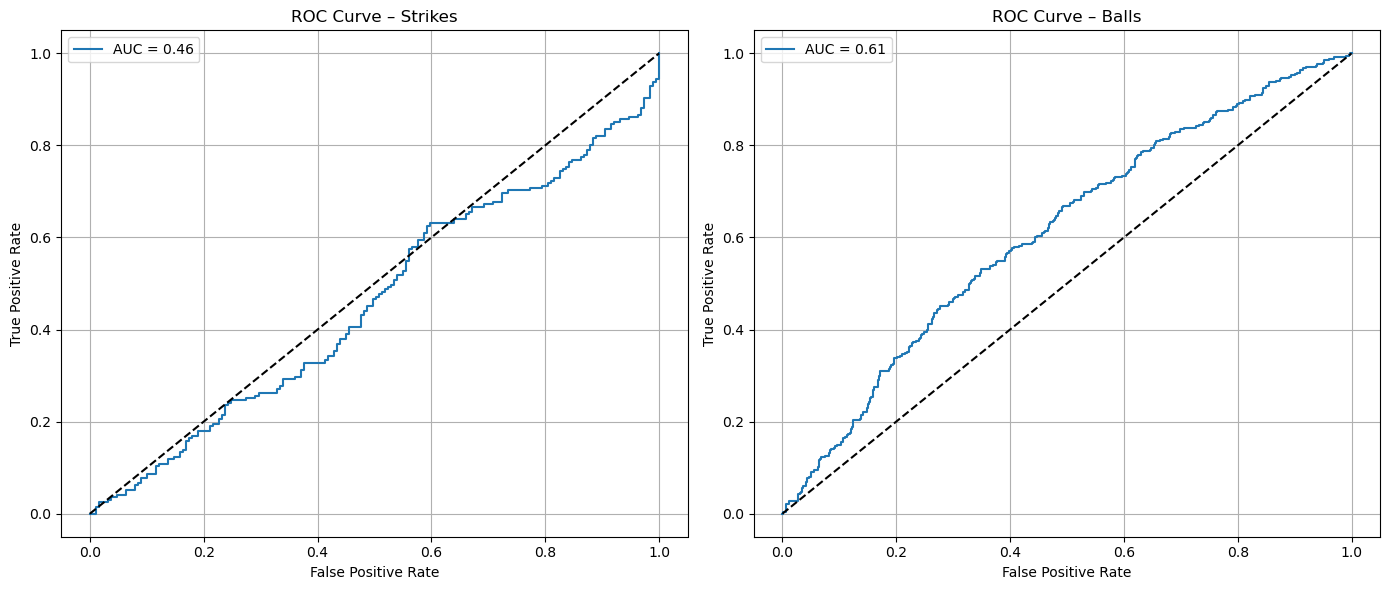

In [29]:
# Get predicted probabilities
y_strikes_scores = LR.prob(X_strikes_clean_tensor)[:, 1]
y_balls_scores = LR.prob(X_balls_clean_tensor)[:, 1]

# Compute ROC curve values
fpr_strikes, tpr_strikes, _ = roc_curve(y_strikes_clean_tensor, y_strikes_scores)
roc_auc_strikes = auc(fpr_strikes, tpr_strikes)

fpr_balls, tpr_balls, _ = roc_curve(y_balls_clean_tensor, y_balls_scores)
roc_auc_balls = auc(fpr_balls, tpr_balls)

# Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize = (14, 6))

# Plot Strike ROC
axs[0].plot(fpr_strikes, tpr_strikes, label = f'AUC = {roc_auc_strikes:.2f}')
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_title('ROC Curve – Strikes')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend()
axs[0].grid()

# Plot Ball ROC
axs[1].plot(fpr_balls, tpr_balls, label = f'AUC = {roc_auc_balls:.2f}')
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_title('ROC Curve – Balls')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend()
axs[1].grid()

# Show both plots
plt.tight_layout()
plt.show()

From our ROC curves, we can see that we have vastly improved our accuracy for predicting whether or not the umpire makes the correct call on ptiches that were strikes, but the model is still performing relatively poorly. As a tradeoff, our model is now performing worse on pitches that were called balls and worse overall. However, a large part of the overall decrease in model performance is likely due to failure to convergence in the training loop. Lets examine the confusion matrix for this model on strikes and balls to understand where the model is making mistakes.

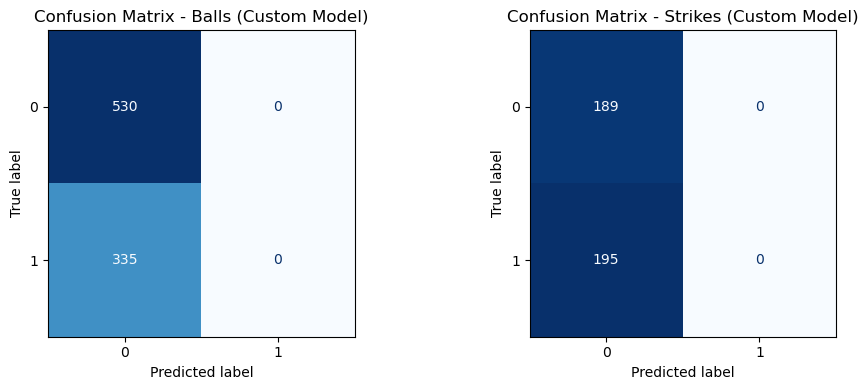

In [33]:
# Generate predictions for balls and strikes
y_pred_balls = LR.predict(X_balls_clean_tensor)
y_pred_strikes = LR.predict(X_strikes_clean_tensor)

# Generate confusion matrices for balls and strikes
cm_balls = confusion_matrix(y_balls, y_pred_balls)
cm_strikes = confusion_matrix(y_strikes, y_pred_strikes)

# === Plotting ===
plt.figure(figsize = (10, 4))

# Plot for Balls
plt.subplot(1, 2, 1)
disp_balls = ConfusionMatrixDisplay(confusion_matrix = cm_balls)
disp_balls.plot(cmap = plt.cm.Blues, ax = plt.gca(), colorbar = False)
plt.title("Confusion Matrix - Balls (Custom Model)")

# Plot for Strikes
plt.subplot(1, 2, 2)
disp_strikes = ConfusionMatrixDisplay(confusion_matrix = cm_strikes)
disp_strikes.plot(cmap = plt.cm.Blues, ax = plt.gca(), colorbar = False)
plt.title("Confusion Matrix - Strikes (Custom Model)")

# Display both plots
plt.tight_layout()
plt.show()


Interestingly our model seems to only be predicting that umpires will make the incorrect call and never predicting that they will make the right call which is of course not true. It just so happens that there are more incorrectlly called balls in the dataset which causes the accuracy for balls to be higher.

Lets explore a secondary feature for both our scikitlearn model and our custom Newton model. How does is umpire accuracy biased by pitcher handedness?

In [ ]:
# Separate into left and right handed datasets
X_left, X_right = X_test_clean[X_test["batSide"] == "L"], X_test_clean[X_test["batSide"] == "R"]
y_left, y_right = y_test_clean[X_test["batSide"] == "L"], y_test_clean[X_test["batSide"] == "R"]

# pull accuracy scores for left handed vs right handed battes fromr the scikitlearn model
left_acc_sci = accuracy_score(y_left, clf.predict(X_left))
right_acc_sci = accuracy_score(y_right, clf.predict(X_right))

# convert to torch tensors and run through our Netwon model
# convet NAs
X_left, X_right = X_left.fillna(0), X_right.fillna(0)

# Preprocess the data with the same processor as the training data
X_left_clean, X_right_clean = preprocessor.transform(X_left), preprocessor.transform(X_right)

# Convert to torch tensors
X_left_tensor, X_right_tensor = torch.tensor(X_left_clean, dtype = torch.float32), torch.tensor(X_right_clean, dtype = torch.float32)
y_left_tensor, y_right_tensor = torch.tensor(y_left.values, dtype = torch.float32), torch.tensor(y_right.values, dtype = torch.float32)

# pull accuracy scores for ptiches that were strikes and pitches that were balls
left_acc_custom = accuracy_score(y_left_tensor, LR.predict(X_left_tensor))
right_acc_custom = accuracy_score(y_right_tensor, LR.predict(X_right_tensor))

# actual accuracy
left_acc_real = np.mean(pitches_not_hit["called_correctly"][pitches_not_hit["batSide"] == "L"])
right_acc_real = np.mean(pitches_not_hit["called_correctly"][pitches_not_hit["batSide"] == "R"])


# tabulate
headers = ["Model", "Left-handed Accuracy", "Right-handed Accuracy"]
data = [
    ["Scikit-Learn Model", f"{left_acc_sci:.4f}", f"{right_acc_sci:.4f}"],
    ["Custom Newton Model", f"{left_acc_custom:.4f}", f"{right_acc_custom:.4f}"],
    ["Actual Umpire Accuracy", f"{left_acc_real:.4f}", f"{right_acc_real:.4f}"],
]

# Display the table
print(tabulate(data, headers = headers, tablefmt = "grid"))


+------------------------+------------------------+-------------------------+
| Model                  |   Left-handed Accuracy |   Right-handed Accuracy |
+========================+========================+=========================+
| Scikit-Learn Model     |                 0.6434 |                  0.7157 |
+------------------------+------------------------+-------------------------+
| Custom Newton Model    |                 0.547  |                  0.5957 |
+------------------------+------------------------+-------------------------+
| Actual Umpire Accuracy |                 0.9183 |                  0.9158 |
+------------------------+------------------------+-------------------------+


C:\Users\miceo\AppData\Local\Temp\ipykernel_21408\1054792401.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_left, X_right = X_test_clean[X_test["batSide"] == "L"], X_test_clean[X_test["batSide"] == "R"]
C:\Users\miceo\AppData\Local\Temp\ipykernel_21408\1054792401.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_left, X_right = X_test_clean[X_test["batSide"] == "L"], X_test_clean[X_test["batSide"] == "R"]
